<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- How to fix dynamic load imbalance
- The concept of search overhead


## The traveling sales person (TSP) problem


### Problem statement

- Given a graph $G$ with a distance table $C$ and an initial node (i.e. a city) in the graph
- Compute the shortest route that visits all cities exactly once, without returning to the initial city.


<div>
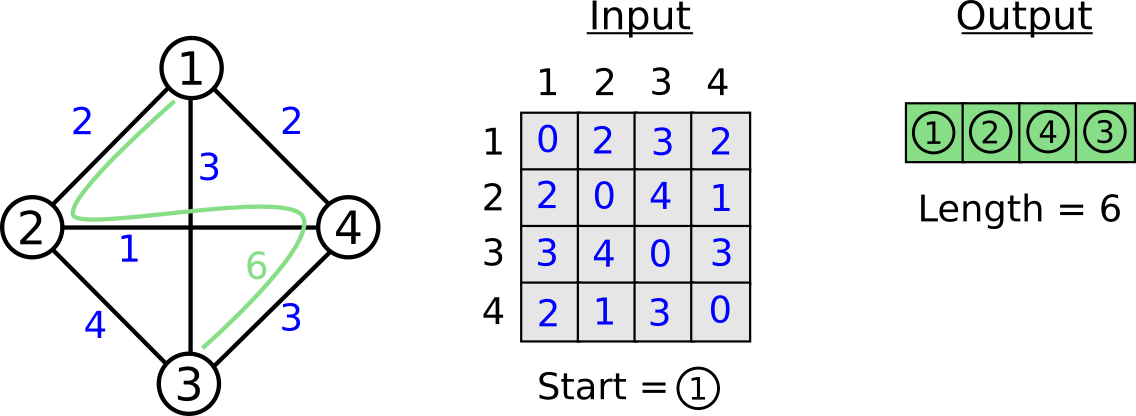
</div>
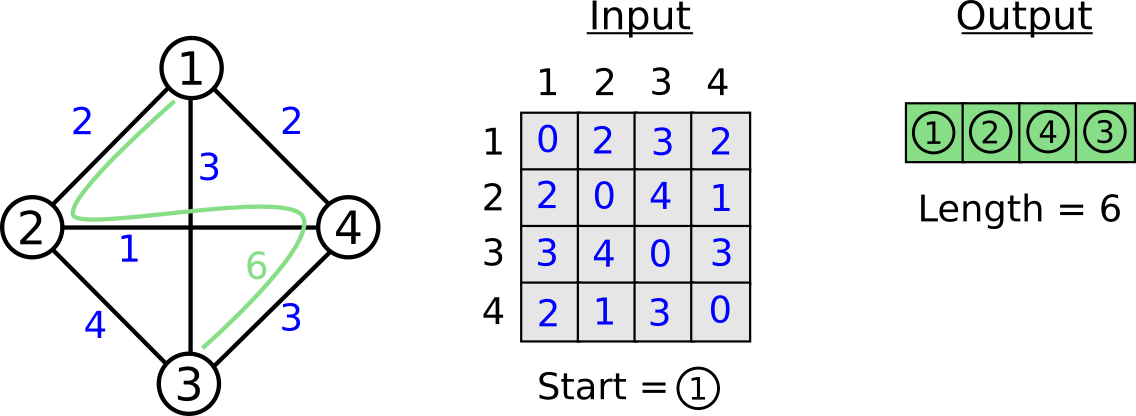

### Branch and bound algorithm

- The root is the initial city
- The children of a node are the neighbor cities not visited so-far
- **We sort the children using the nearest city first heuristic**
- A node will be a leaf of the tree when all neighbor cities are already visited


<div>
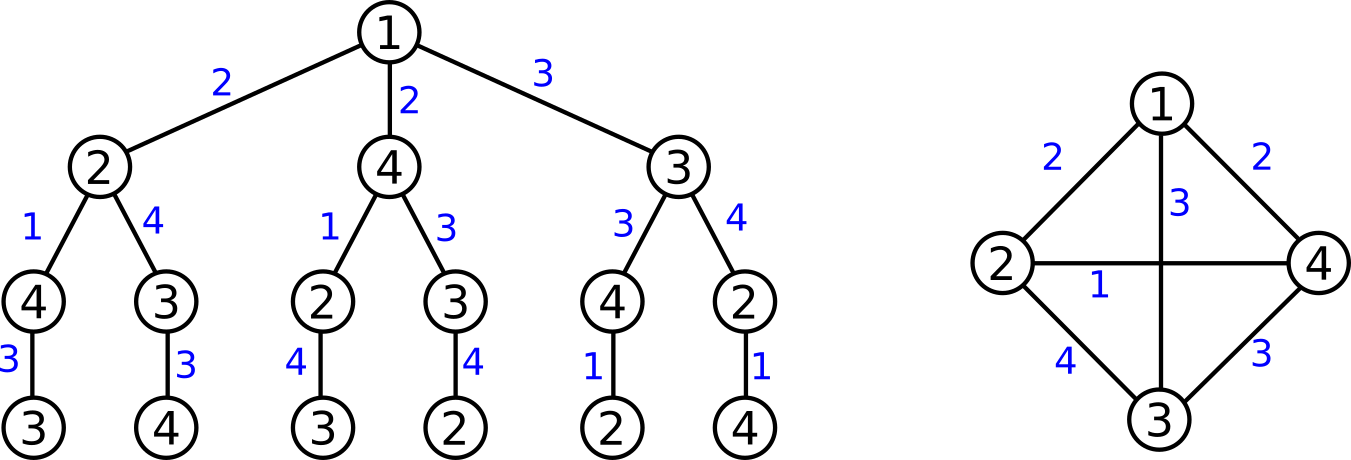
</div>
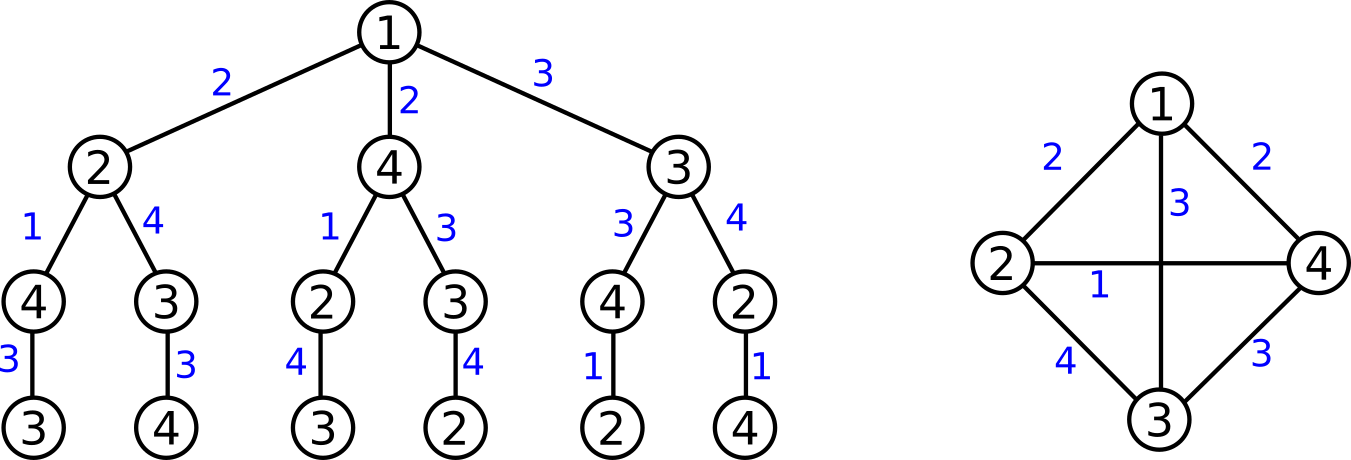

- Number of possible paths might be up to O(N!)
- Visiting all paths is impractical (even in parallel)

### Pruning the search tree


- Only 3 out of 6 routes need to be visited

<div>
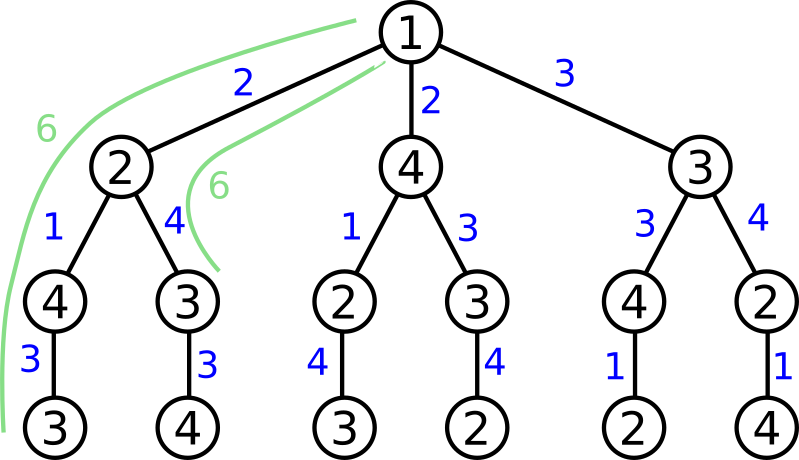
</div>
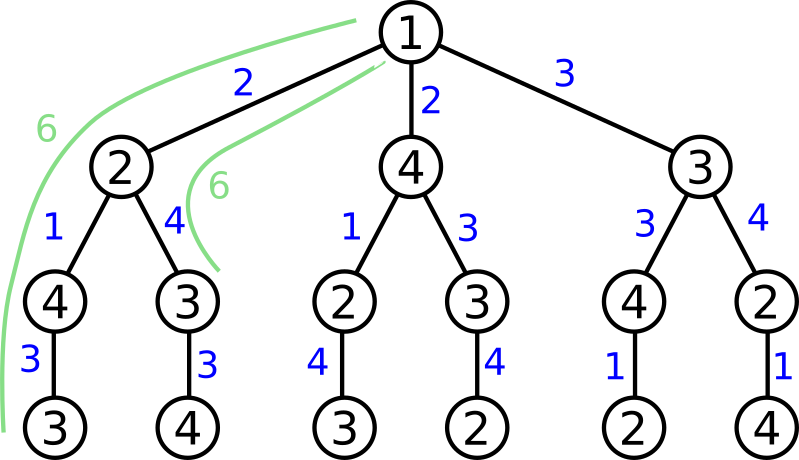

<div>
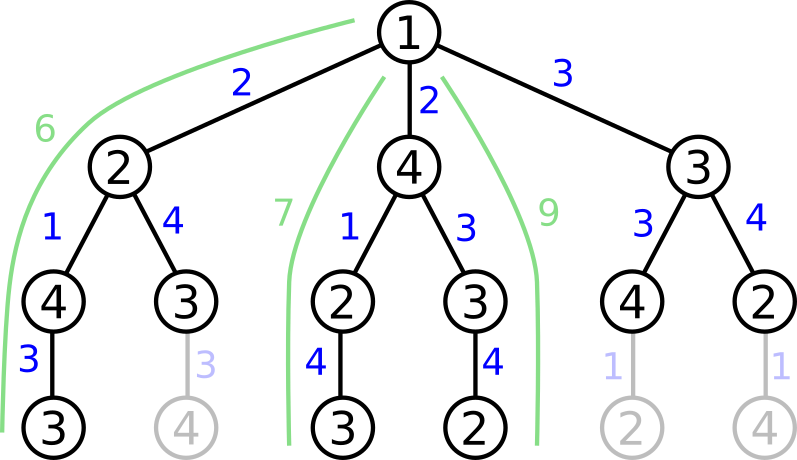
</div>
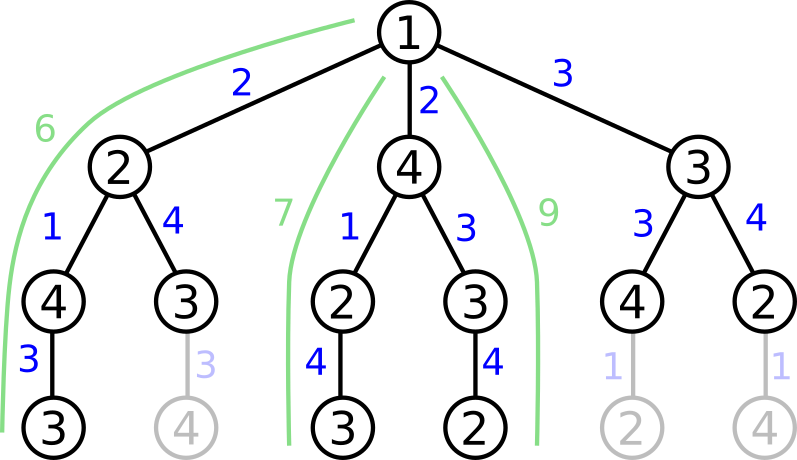

## Serial implementation

### Nearest-city first heuristic

In [ ]:
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))
    end
end

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]

In [ ]:
C_sorted = sort_neighbors(C)

In [ ]:
city = 3
C_sorted[city]

<div>
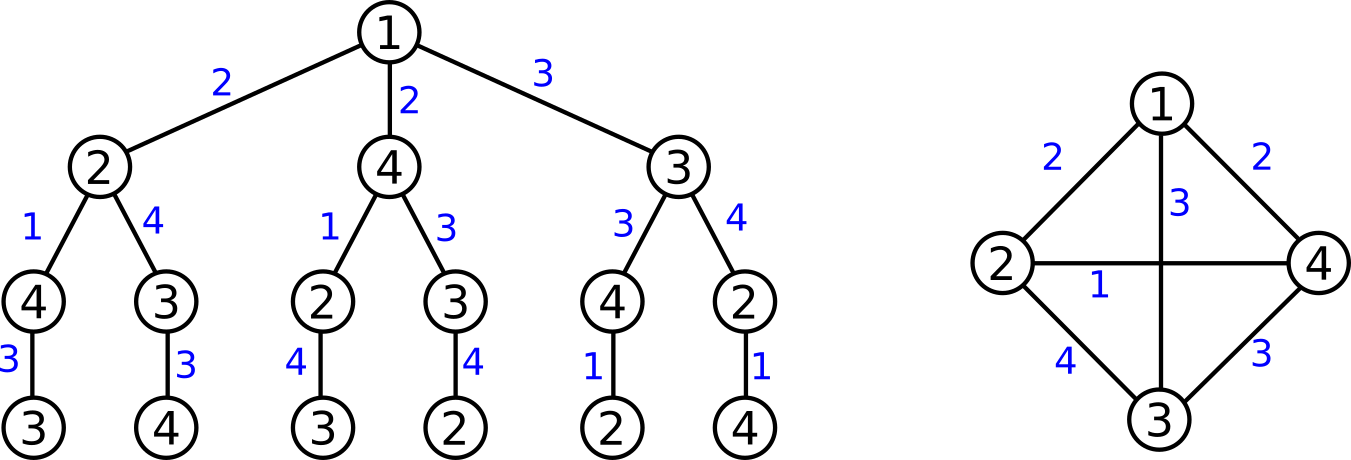
</div>
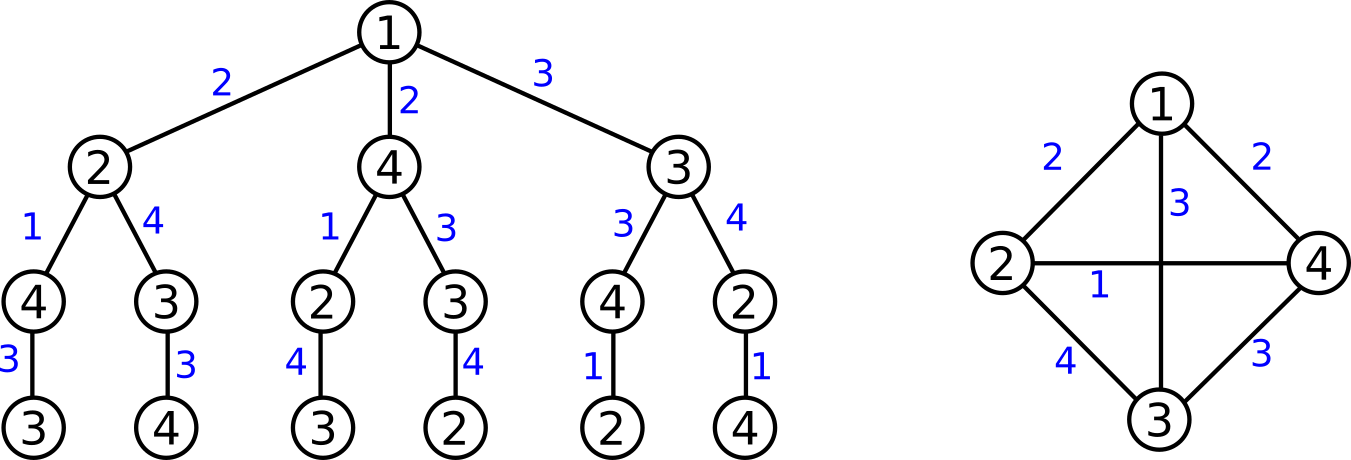

### Loop over all paths

In [ ]:
function visital_all_paths(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    visital_all_paths_recursive!(C_sorted,hops,path)
end
function visital_all_paths_recursive!(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                visital_all_paths_recursive!(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        #@show path
        println(path)
        return nothing
    end
end

In [ ]:
city = 1
visital_all_paths(C_sorted,city)

<div>
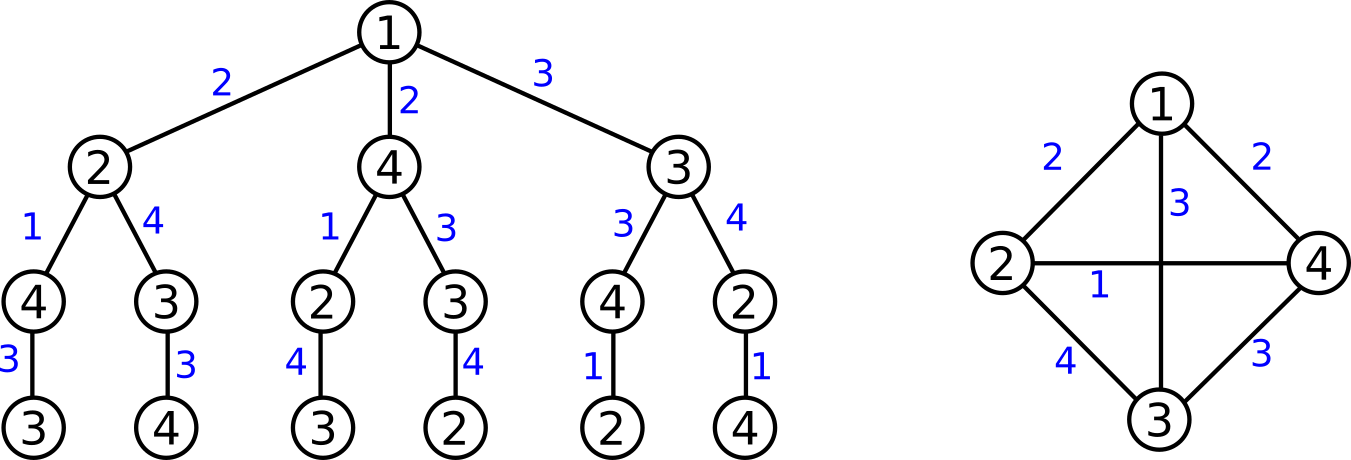
</div>
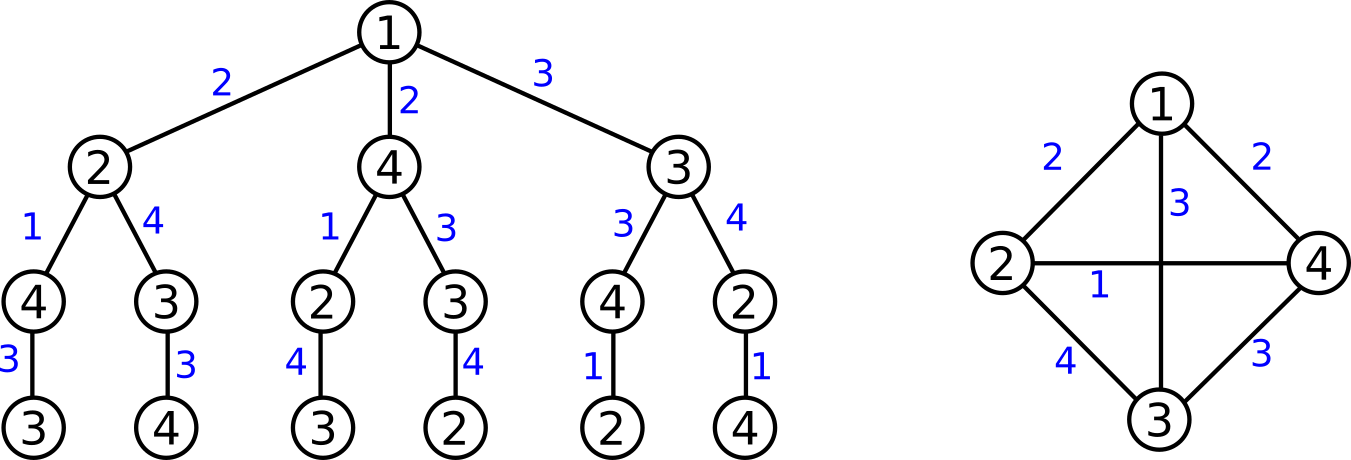

### Serial implementation without pruning

- Now, we add the computation of the minimum distance

In [ ]:
function tsp_serial_no_prune(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_no_prune_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
min_distance = tsp_serial_no_prune(C_sorted,city)

### Final serial implementation

- Now, we add pruning

In [ ]:
function tsp_serial(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
min_distance = tsp_serial(C_sorted,city)

### Performance

In [ ]:
n = 12 # It is safe to test up to 12
using Random
using Test
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
@time min_no_prune = tsp_serial_no_prune(C_sorted,city)
@time min_prune = tsp_serial(C_sorted,city)
@test min_no_prune == min_prune

## Parallel implementation

### Where can we extract parallelism ?

<div>
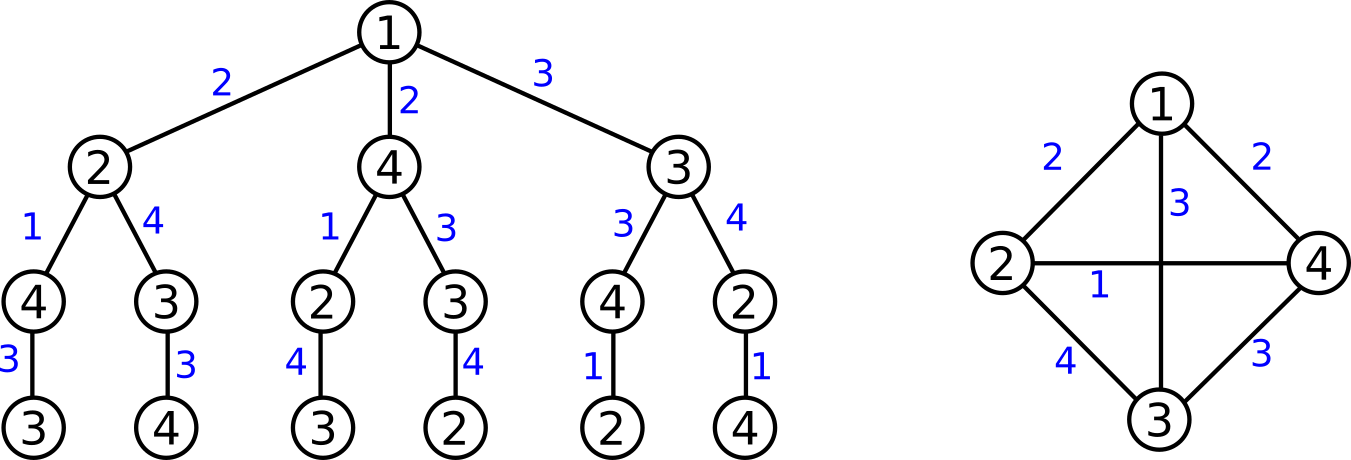
</div>
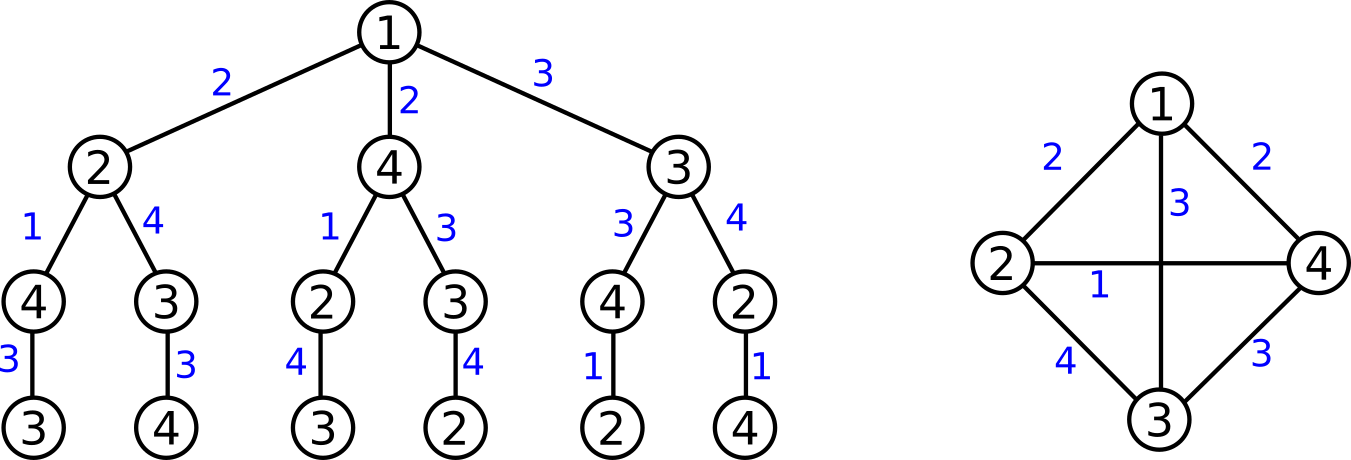

### Option 1

- We assign a branch to each worker
- Pros? Cons?


<div>
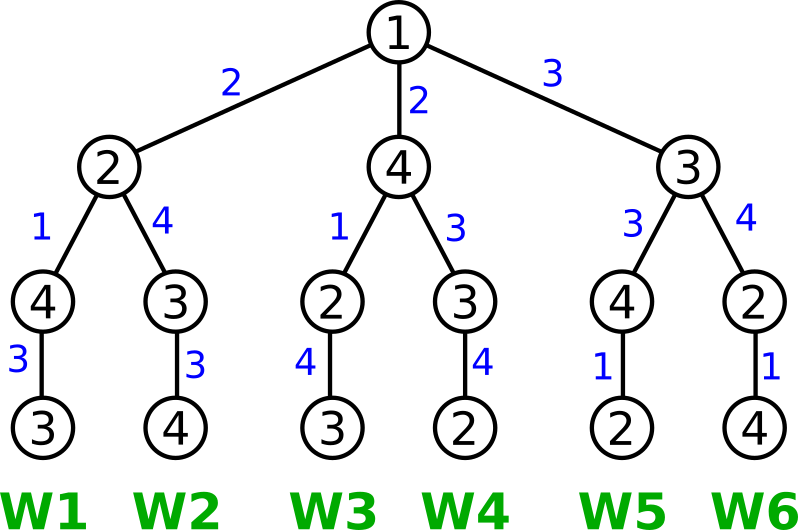
</div>
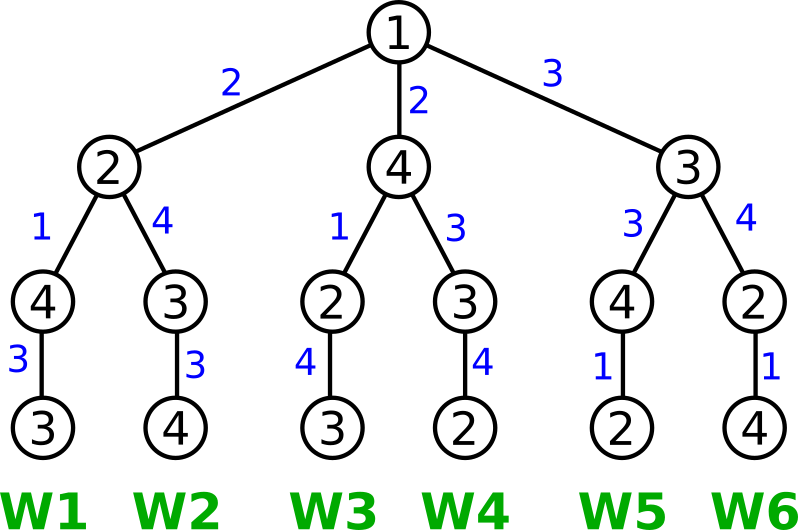

### Option 2
- We assign a fixed number of branches to each worker in advance
- Pros? Cons?

<div>
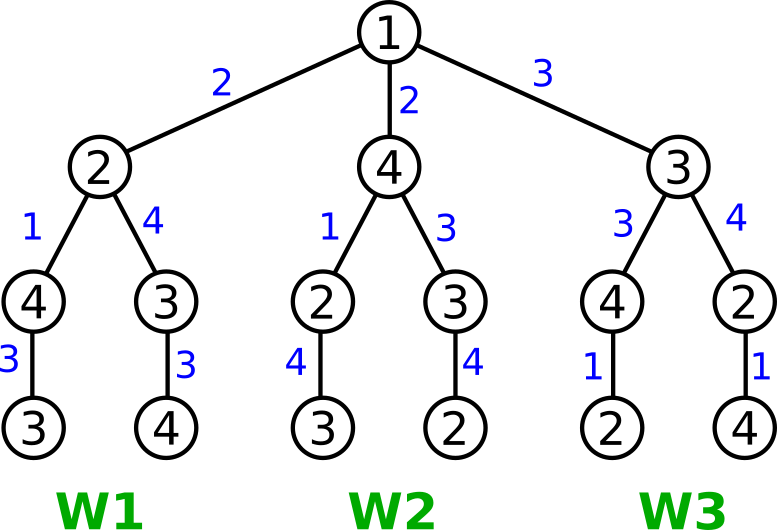
</div>
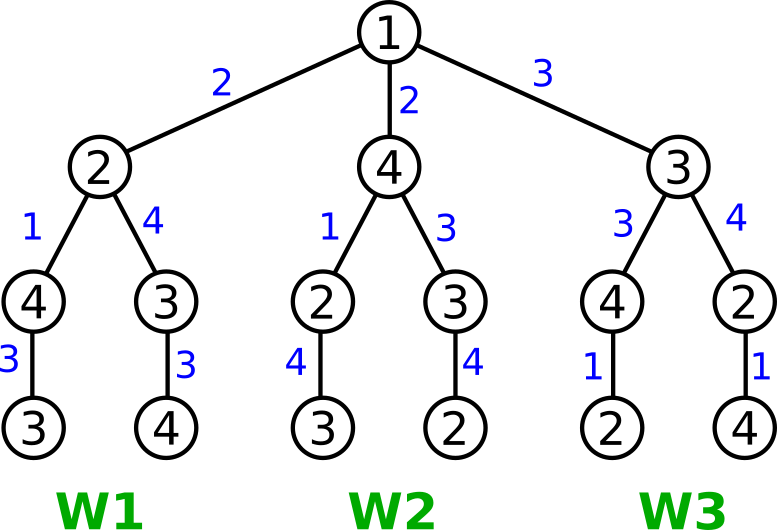

<div>
    <br>
    <br>
    <br>
</div>

<div>
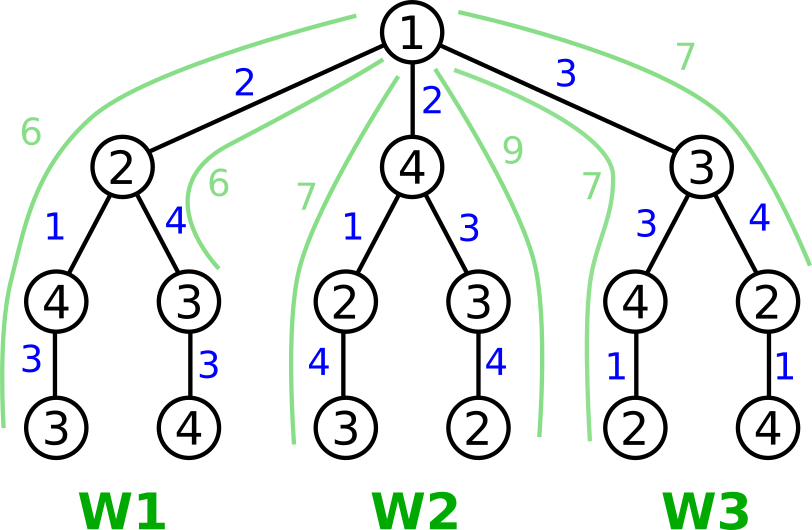
</div>
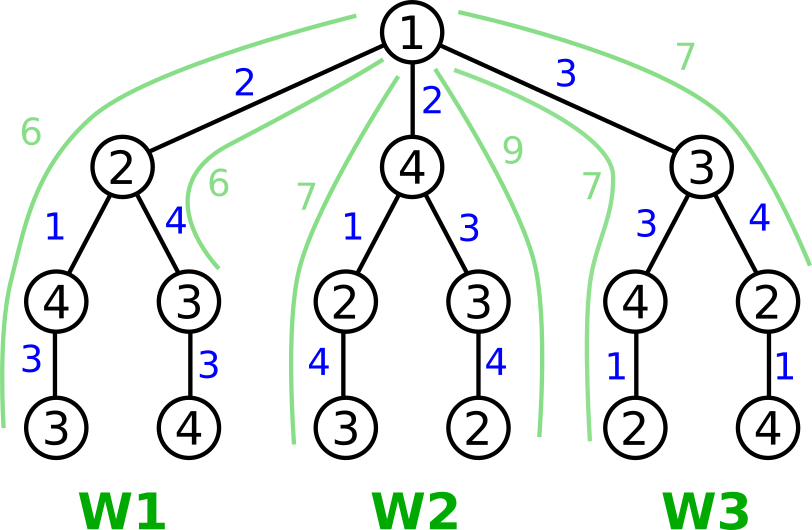

### Main performance issues

- Dynamic load imbalance
- Search overhead

### Dynamic load balancing with replicated workers model

- The coordinator searches up to a certain depth in the tree
- When the maximum depth is reached, the coordinator delegates the search to a worker
- Worker processes repeatedly get work and execute it


<div>
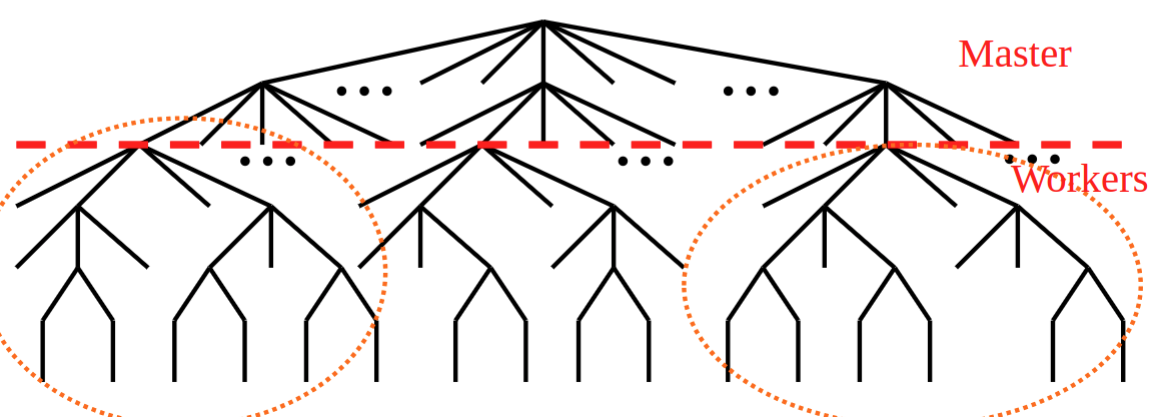
</div>
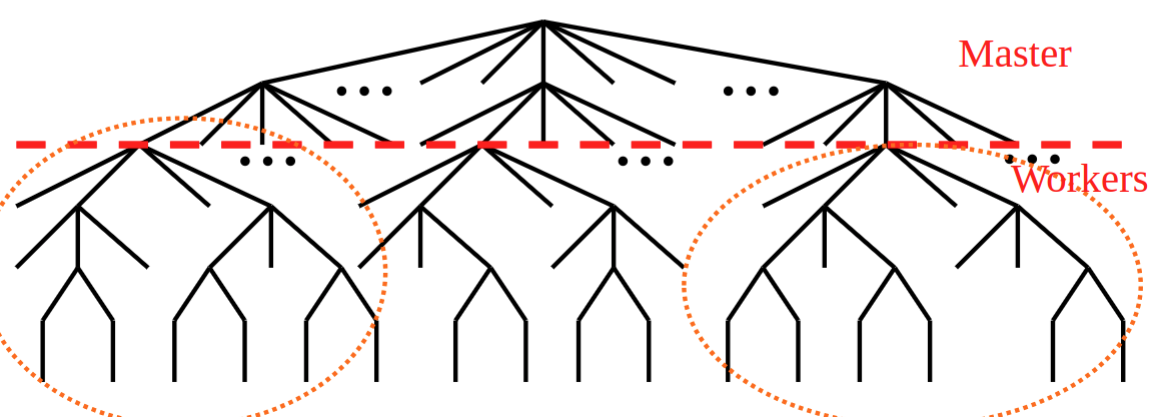

### Code

In [ ]:
using Distributed

In [ ]:
if workers() == procs()
    addprocs(3)
end

### Visit paths in parallel

- We follow a produce-consumer model using a remote channel

In [ ]:
function visit_all_paths_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[]))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    if hops == max_hops
        @show path
        put!(jobs_chnl,(hops,copy(path)))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(C_sorted,next_hops,path,max_hops,jobs_chnl)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl)
    while true
        try
            hops,path = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path)
        catch
            break
        end        
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                consume_jobs_recursive(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        @show path
        return nothing
    end
end

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]
C_sorted = sort_neighbors(C)
city = 1
max_hops = 2
min_distance = visit_all_paths_dist(C_sorted,city,max_hops)

### How to track the global minimum distance?


<div>
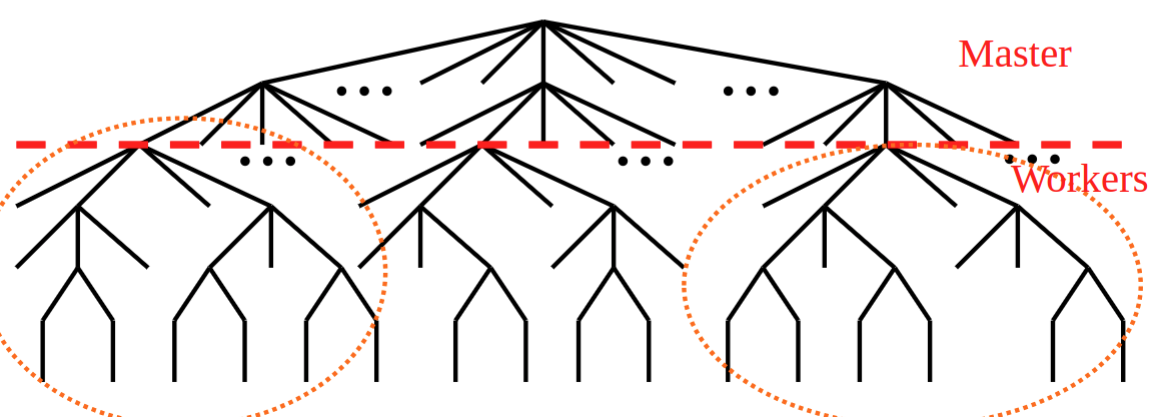
</div>
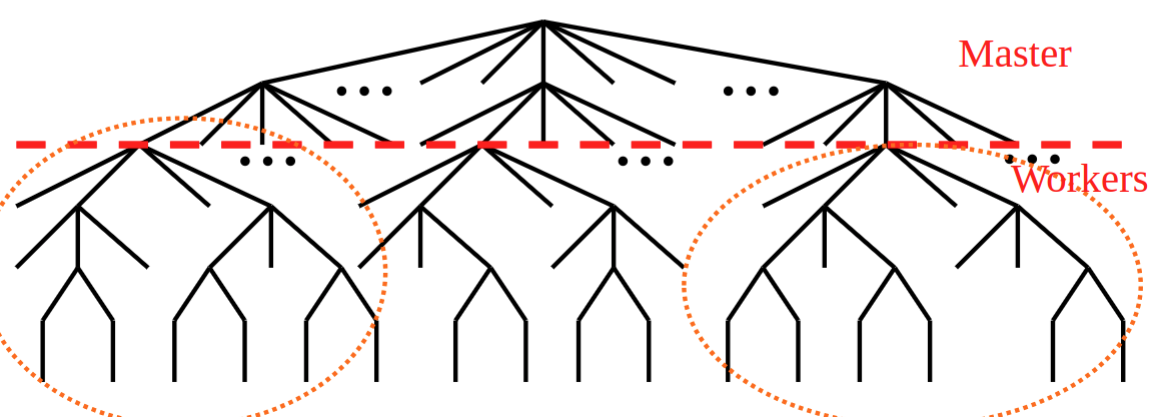


### Simplified example

- Each worker generates a random value and updates a globally shared minimum

In [ ]:
buffer = 1 # Very important
min_distance_chnl = RemoteChannel(()->Channel{Int}(buffer))
put!(min_distance_chnl,typemax(Int))
@sync for w in workers()
    @spawnat w begin
         sleep(rand(1:3))
         min_distance = take!(min_distance_chnl)
         @show min_distance
         distance = rand(5:10)
         min_distance = min(distance,min_distance)
         @show distance
         put!(min_distance_chnl,min_distance)
    end
end
min_distance = take!(min_distance_chnl)
@show min_distance
close(min_distance_chnl)

### Final parallel implementation

In [ ]:
function tsp_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[],0))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    min_distance_chnl = RemoteChannel(()->Channel{Int}(1))
    put!(min_distance_chnl,typemax(Int))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
    min_distance = take!(min_distance_chnl)
    close(min_distance_chnl)
    return min_distance
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance = 0
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
    num_cities = length(C_sorted)
    if hops == max_hops
        #@show path, distance
        put!(jobs_chnl,(hops,copy(path),distance))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(
                        C_sorted,next_hops,path,max_hops,jobs_chnl,next_distance)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
    while true
        min_distance = take!(min_distance_chnl)
        put!(min_distance_chnl,min_distance)
        try
            hops,path,distance = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
        catch
            break
        end
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                min_distance = consume_jobs_recursive(
                        C_sorted,next_hops,path,min_distance_chnl,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = take!(min_distance_chnl)
        min_distance = min(min_distance,distance)
        put!(min_distance_chnl,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
max_hops = 2
min_distance = tsp_dist(C_sorted,city,max_hops)

In [ ]:
n = 18 # Safe to run up to 18
using Random
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
T1 = @elapsed min_serial = tsp_serial(C_sorted,city)
max_hops = 2
P = nworkers()
TP = @elapsed min_dist = tsp_dist(C_sorted,city,max_hops)
println("Sequential time = ", T1)
println("Parallel time = ", TP)
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")
@test min_serial == min_dist